In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


### Installing NeuralForecast (If Required)

In [2]:
# %%capture
# !pip install neuralforecast

### Common Imports

In [3]:
import numpy as np
import pandas as pd

### Common Functions and metrics

- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.

In [4]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

### Loading M4 Data

Let's load the data and pick 8 time series to work with.

In [5]:
from src.utils.general import download_m4_data
import os
if not os.path.exists('data/m4/M4-Hourly.csv'):
    download_m4_data()
Y_train_df = pd.read_csv('data/m4/M4-Hourly.csv')
Y_test_df = pd.read_csv('data/m4/M4-Hourly-test.csv')#.rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [6]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

### Plotting Sampled TS

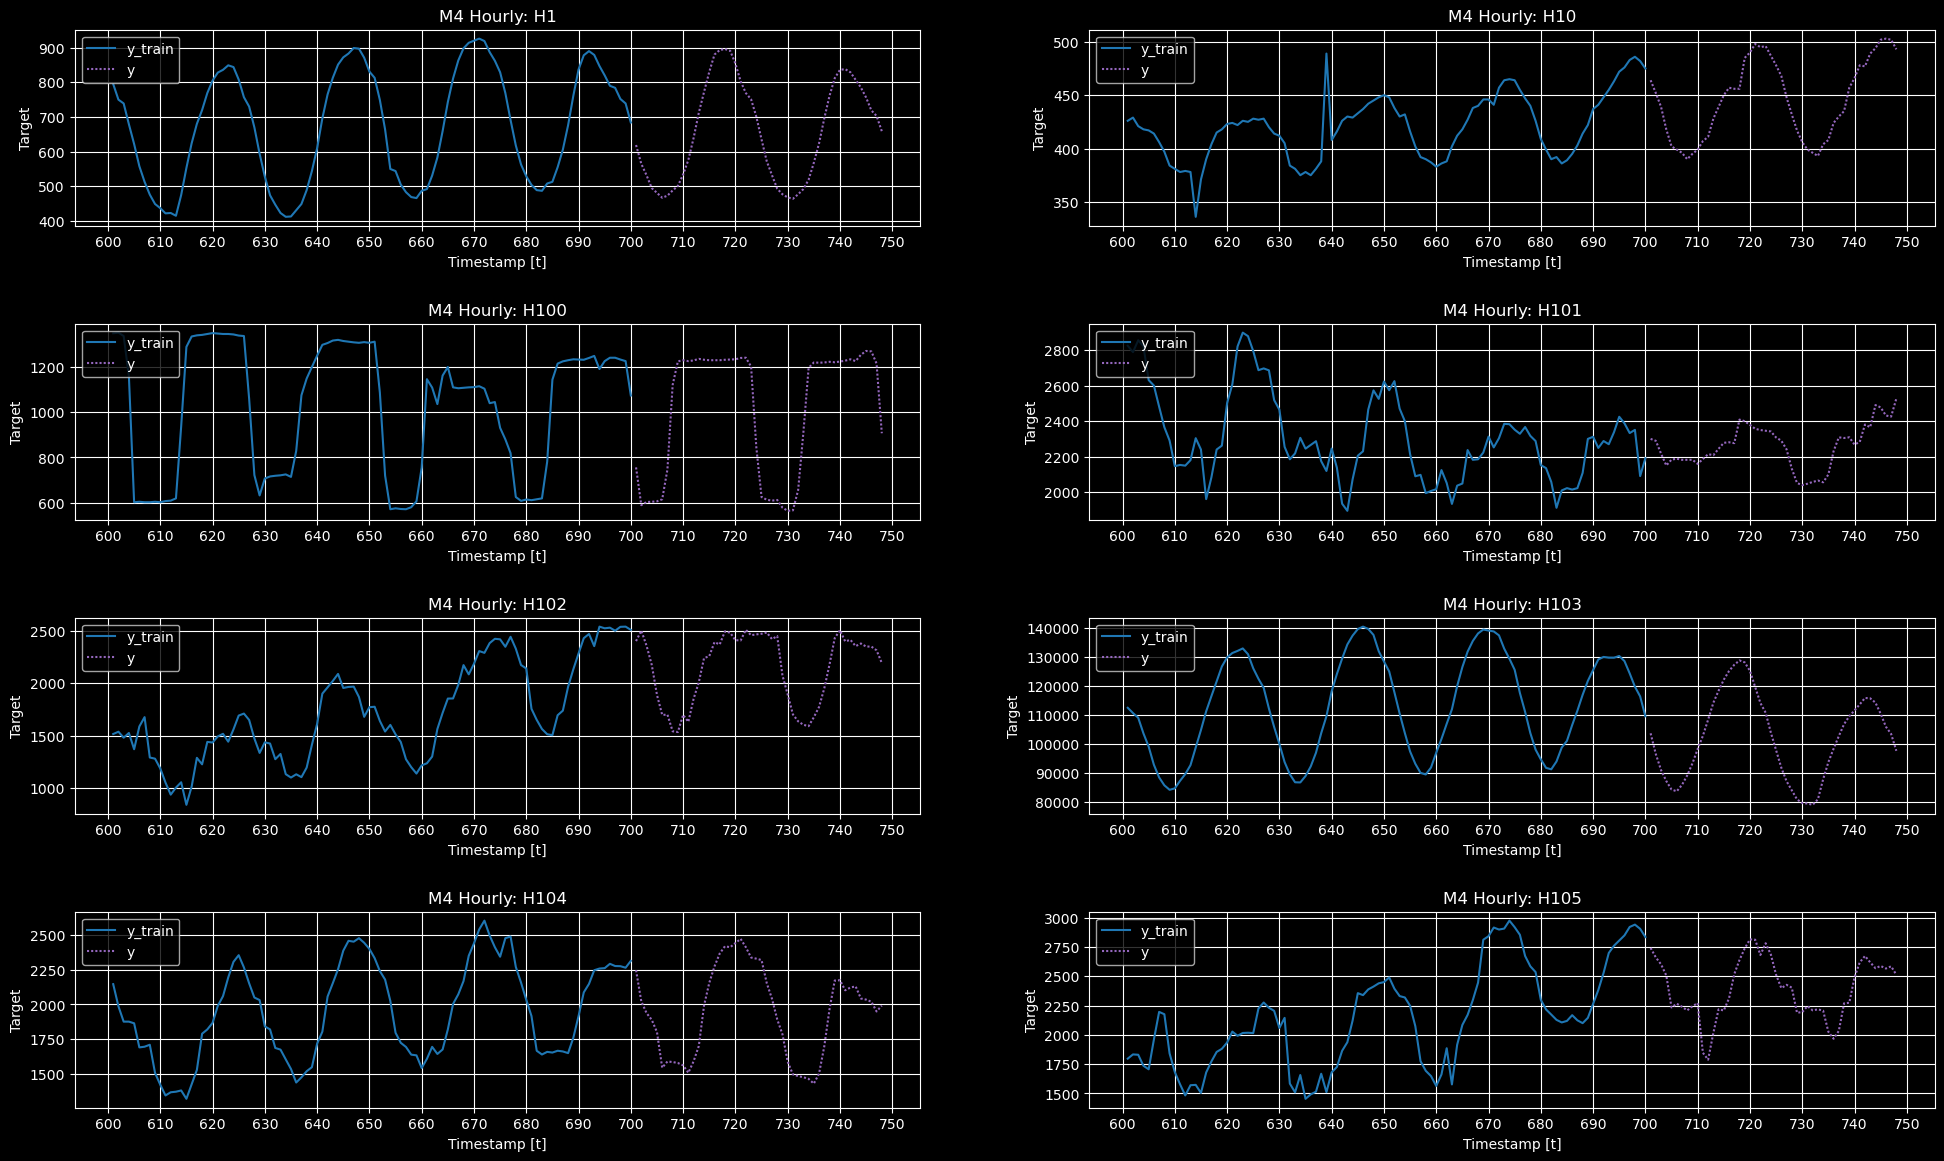

In [7]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Model Training

We have already seen how to use `neuralforecast` in Chapter 16. Here, lets see how we can use the same code and make it work for Quantile prediction. We are going to use a simple LSTM, but the same strategy and code can be used for all the models in `neuralforecast`.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `DistributionLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals.
- `input_size` controls the size of the context window
- `encoder_hidden_size` and `decoder_hidden_size` are parameters of the LSTM. We have kept it small so that the run's are faster. These parameters should be ideally tuned and we can use `AutoLSTM` or any of the `Auto<Model>` in `neuralforecast`.

In [8]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import LSTM
from neuralforecast.losses.pytorch import MQLoss

In [9]:
horizon = len(Y_test_df.ds.unique()) # 48
levels = [80, 90]
lstm_config = dict(
    input_size=3 * horizon
)
models = [LSTM(h=horizon, loss=MQLoss(level=levels), alias="LSTM_QR", **lstm_config)]
# Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
nf = NeuralForecast(models=models, freq=1)

Seed set to 1


All the models of the library are global, meaning that all time series in `Y_train_df` is used during a shared optimization to train a single model with shared parameters. This is the most common practice in the forecasting literature for deep learning models, and it is known as "cross-learning".

In [10]:
%%capture
nf.fit(df=Y_train_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MQLoss        | 5     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 484 K 
4 | context_adapter | Linear        | 96.5 K
5 | mlp_decoder     | MLP           | 3.2 K 
--------------------------------------------------
583 K     Trainable params
5         Non-trainable params
583 K     Total params
2.335     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=1000` reached.


In [11]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point rediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM_QR-median,LSTM_QR-lo-90,LSTM_QR-lo-80,LSTM_QR-hi-80,LSTM_QR-hi-90
0,H1,701,595.739563,509.562042,536.167969,642.396851,670.277893
1,H1,702,540.314697,433.306946,464.785522,604.624146,636.411072
2,H1,703,493.031097,367.928497,410.444458,573.558716,603.604675
3,H1,704,459.343323,333.415405,375.255951,544.380981,576.579407
4,H1,705,440.466370,320.767731,343.908844,528.508362,566.995178


In [12]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

### Plotting Predictions

Let's plot the forecast and see how we did.

The output that represents the 90% prediction interval of the network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

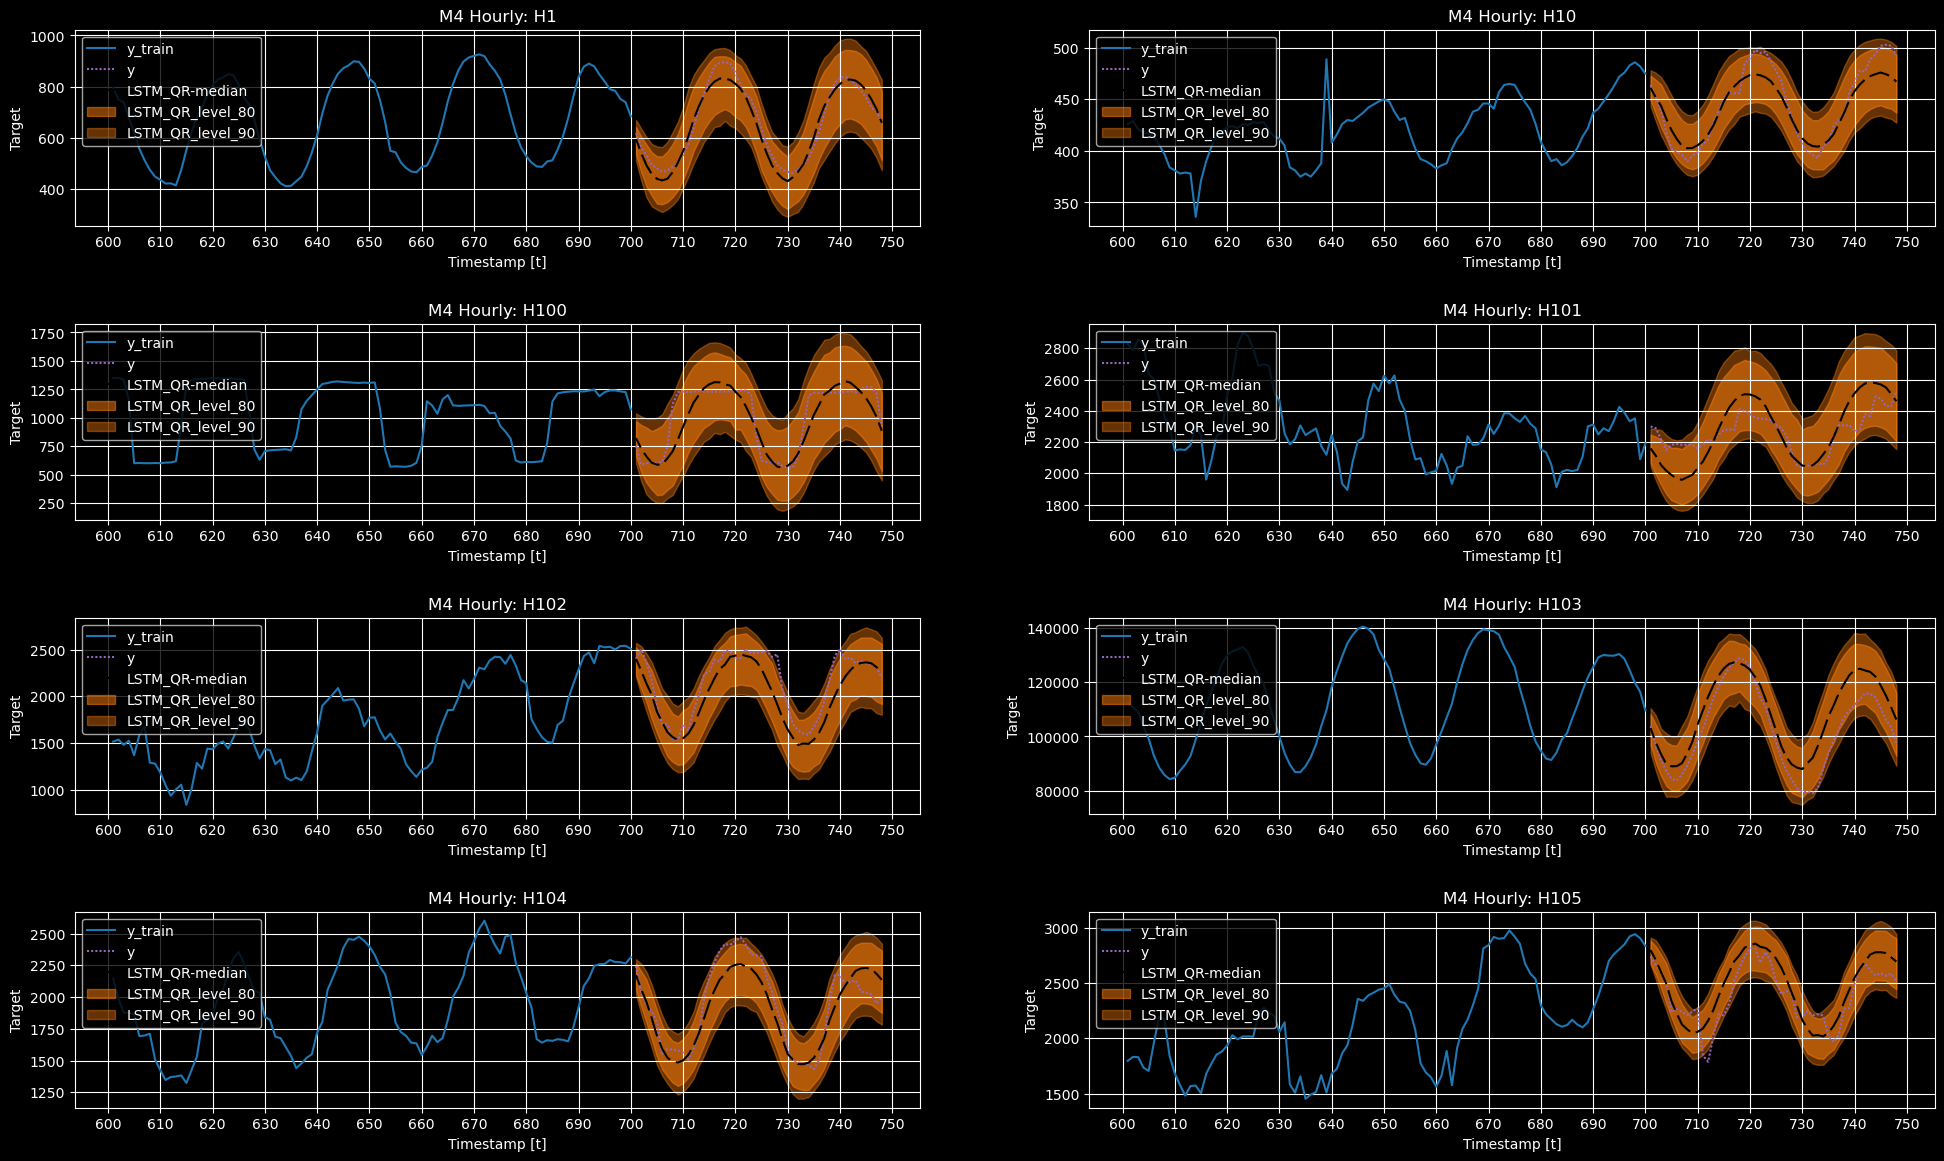

In [13]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_QR')

#### Metrics

In [14]:
from utilsforecast.losses import mae, coverage

In [15]:
res_df = mae(Y_test_df, models=['LSTM_QR-median']).rename(columns={'LSTM_QR-median': 'LSTM_QR-mae'})
for l in levels:
    res_df = res_df.merge(coverage(Y_test_df, models=['LSTM_QR'], level=l).rename(columns={'LSTM_QR': f'LSTM_QR-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['LSTM_QR'], level=l).rename(columns={'LSTM_QR': f'LSTM_QR-average_length-{l}'}), on='unique_id')
res_df

,unique_id,LSTM_QR-mae,LSTM_QR-coverage-80,LSTM_QR-average_length-80,LSTM_QR-coverage-90,LSTM_QR-average_length-90
0,H1,27.676745,1.000000,230.414394,1.000000,310.013259
1,H10,10.807311,0.875000,50.416717,1.000000,66.884124
2,H100,97.728085,0.958333,637.760490,1.000000,840.947469
3,H101,105.142062,0.854167,442.864621,0.958333,569.728546
4,H102,147.583364,0.854167,567.665464,0.937500,755.053749
5,H103,6551.779785,0.895833,20368.561686,0.979167,27244.118815
6,H104,111.855413,0.812500,409.256465,0.979167,551.699509
7,H105,131.969488,0.770833,386.110799,0.937500,514.795191
